In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from os import listdir
from os.path import join
from sklearn import metrics
init_notebook_mode()


In [2]:
def generate_data(mu=0,sigma=0.3):
    t=np.arange(0,10,0.01)
    s = np.random.normal(mu, sigma, 1000)
    x=(np.sin(2*np.pi*t)+s)
    return x
x=generate_data()

In [3]:
def data_preparation(data,time_wind,batch_size=90,output=1):
    data_train=data[:901]
    x_train=[]
    for i in range((len(data_train)-1)-(time_wind-1)):
        x_train.append(data_train[i:(i+time_wind)])
    x_train=np.array(x_train)
    x_batches=(x_train[:(len(x_train)-(len(x_train)%batch_size))]).reshape(-1,batch_size,time_wind)
    #x_batches=x_train.reshape(-1,batch_size,time_wind)
    y_train=data_train[time_wind:len(data_train)]#+3]
    y_batches=(y_train[:(len(y_train)-(len(y_train)%batch_size))]).reshape(-1,batch_size,output)
    #y_batches=y_train.reshape(-1,batch_size,output)
    data_test=data[902:]
    x_t=[]
    for i in range((len(data_test)-1)-(time_wind-1)):
        x_t.append(data_test[i:(i+time_wind)])
    x_t=np.array(x_t)
    x_test=(x_t[:(len(x_t)-(len(x_t)%batch_size))]).reshape(-1,batch_size,time_wind)
    #x_test=x_t.reshape(-1,batch_size,time_wind)
    y_t=data_test[time_wind:len(data_test)]
    y_test=(y_t[:(len(y_t)-(len(y_t)%batch_size))]).reshape(-1,batch_size,output)
    #y_test=y_t.reshape(-1,batch_size,output)
    return x_batches, y_batches, x_test, y_test

In [4]:
def run_graph(epochs,time_wind,hidden=150,learning_rat=0.0065,output=1,batch_size=90):
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,batch_size,time_wind])
    Y=tf.placeholder(tf.float32,[None,batch_size,output])
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden)#,activation=tf.nn.relu)
    rnn_output, states=tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)
    stacked_rnn_output=tf.reshape(rnn_output,[-1,hidden])
    stacked_outputs=tf.layers.dense(stacked_rnn_output,output)
    outputs=tf.reshape(stacked_outputs,[-1,batch_size,output])
    loss=tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rat)
    training_op=optimizer.minimize(loss)
    
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            sess.run(training_op,feed_dict={X: x_batches, Y: y_batches})
            if ep % 100 == 0:
                mse=loss.eval(feed_dict={X: x_batches, Y: y_batches})
                print(ep,"\tMSE:",mse)
        y_pred=sess.run(outputs,feed_dict={X:x_test})
        mse_test=loss.eval(feed_dict={X:x_test,Y:y_test})
    #NMSE=(mse/len(x_train))/np.var(x_train)
    #NMSE_test=(mse_test/len(x_test.reshape(-1)))/np.var(x_test.reshape(-1))
        print(mse)
        print(mse_test)
    sess.close() 
    return mse_test, y_pred

In [5]:
def visualisation():
    plt.plot(y_test[0],label='Actual')
    plt.plot(y_pred[0],label='Forecast')
    plt.legend(loc="upper left")
    return plt.show

0 	MSE: 2.07045
100 	MSE: 1.35613
200 	MSE: 0.942562
300 	MSE: 0.696783
400 	MSE: 0.523298
0.523298
0.381293
0 	MSE: 1.54556
100 	MSE: 1.29684
200 	MSE: 1.08517
300 	MSE: 0.927633
400 	MSE: 0.820586
0.820586
0.912134
0 	MSE: 0.397816
100 	MSE: 0.330171
200 	MSE: 0.263411
300 	MSE: 0.20987
400 	MSE: 0.177358
0.177358
0.162764
0 	MSE: 0.515968
100 	MSE: 0.4512
200 	MSE: 0.380388
300 	MSE: 0.312784
400 	MSE: 0.258909
0.258909
0.252172
0 	MSE: 1.31932
100 	MSE: 0.796031
200 	MSE: 0.534327
300 	MSE: 0.341507
400 	MSE: 0.194246
0.194246
0.10928
0 	MSE: 1.46253
100 	MSE: 1.16711
200 	MSE: 0.957802
300 	MSE: 0.825481
400 	MSE: 0.741027
0.741027
0.631011
0 	MSE: 2.65031
100 	MSE: 2.10582
200 	MSE: 1.65756
300 	MSE: 1.33585
400 	MSE: 1.11442
1.11442
1.14403
0 	MSE: 2.38837
100 	MSE: 1.46051
200 	MSE: 1.21477
300 	MSE: 1.10029
400 	MSE: 1.05537
1.05537
0.81563
0 	MSE: 4.10737
100 	MSE: 3.61918
200 	MSE: 2.78272
300 	MSE: 1.27417
400 	MSE: 1.01718
1.01718
0.874433
0 	MSE: 1.13766
100 	MSE: 0.96463

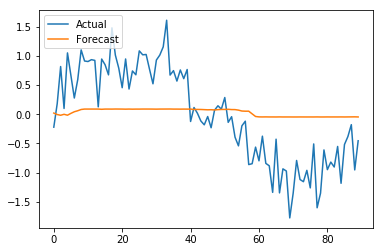

In [6]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(500,1,hidden=1,learning_rat=0.001)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

0 	MSE: 1.97081
100 	MSE: 1.67626
200 	MSE: 1.41166
300 	MSE: 1.15391
400 	MSE: 0.929399
500 	MSE: 0.77212
600 	MSE: 0.673117
700 	MSE: 0.609277
800 	MSE: 0.566137
900 	MSE: 0.532983
0.532983
0.511923
0 	MSE: 0.175902
100 	MSE: 0.137165
200 	MSE: 0.130718
300 	MSE: 0.127338
400 	MSE: 0.125551
500 	MSE: 0.124613
600 	MSE: 0.12412
700 	MSE: 0.123854
800 	MSE: 0.1237
900 	MSE: 0.123598
0.123598
0.0998659
0 	MSE: 0.336435
100 	MSE: 0.260278
200 	MSE: 0.214766
300 	MSE: 0.185576
400 	MSE: 0.16727
500 	MSE: 0.155753
600 	MSE: 0.148316
700 	MSE: 0.143349
800 	MSE: 0.139957
900 	MSE: 0.13761
0.13761
0.112522
0 	MSE: 0.665707
100 	MSE: 0.617845
200 	MSE: 0.595623
300 	MSE: 0.580481
400 	MSE: 0.550661
500 	MSE: 0.460251
600 	MSE: 0.28646
700 	MSE: 0.169332
800 	MSE: 0.137418
900 	MSE: 0.131635
0.131635
0.131527
0 	MSE: 0.769518
100 	MSE: 0.456021
200 	MSE: 0.185311
300 	MSE: 0.12369
400 	MSE: 0.121342
500 	MSE: 0.119911
600 	MSE: 0.118774
700 	MSE: 0.117887
800 	MSE: 0.117203
900 	MSE: 0.116682


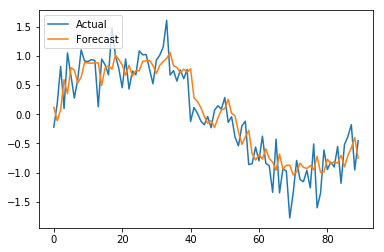

In [7]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(1000,1,hidden=1,learning_rat=0.001)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

0 	MSE: 0.328797
100 	MSE: 0.224237
200 	MSE: 0.163503
300 	MSE: 0.135998
400 	MSE: 0.127553
500 	MSE: 0.125872
600 	MSE: 0.125482
700 	MSE: 0.125241
800 	MSE: 0.125034
900 	MSE: 0.124854
1000 	MSE: 0.124698
1100 	MSE: 0.124563
1200 	MSE: 0.124445
1300 	MSE: 0.124341
1400 	MSE: 0.124249
0.124249
0.117877
0 	MSE: 0.770479
100 	MSE: 0.687917
200 	MSE: 0.631667
300 	MSE: 0.591279
400 	MSE: 0.557171
500 	MSE: 0.519265
600 	MSE: 0.466951
700 	MSE: 0.397646
800 	MSE: 0.32232
900 	MSE: 0.256907
1000 	MSE: 0.20969
1100 	MSE: 0.179826
1200 	MSE: 0.162677
1300 	MSE: 0.153529
1400 	MSE: 0.148871
0.148871
0.121916
0 	MSE: 0.57581
100 	MSE: 0.506134
200 	MSE: 0.347136
300 	MSE: 0.229538
400 	MSE: 0.182565
500 	MSE: 0.1632
600 	MSE: 0.152687
700 	MSE: 0.145927
800 	MSE: 0.141324
900 	MSE: 0.138127
1000 	MSE: 0.135888
1100 	MSE: 0.13431
1200 	MSE: 0.133195
1300 	MSE: 0.132404
1400 	MSE: 0.131841
0.131841
0.111001
0 	MSE: 0.197803
100 	MSE: 0.159661
200 	MSE: 0.144527
300 	MSE: 0.136732
400 	MSE: 0.13

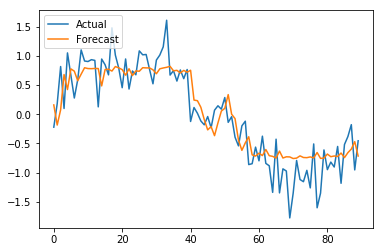

In [8]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(1500,1,hidden=1,learning_rat=0.001)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

0 	MSE: 0.607805
100 	MSE: 0.510317
200 	MSE: 0.418675
300 	MSE: 0.344234
400 	MSE: 0.285769
500 	MSE: 0.241509
600 	MSE: 0.209144
700 	MSE: 0.186154
800 	MSE: 0.170162
900 	MSE: 0.159156
1000 	MSE: 0.151592
1100 	MSE: 0.146366
1200 	MSE: 0.142712
1300 	MSE: 0.140094
1400 	MSE: 0.138142
1500 	MSE: 0.136605
1600 	MSE: 0.135322
1700 	MSE: 0.134198
1800 	MSE: 0.133183
1900 	MSE: 0.132253
0.132253
0.126329
0 	MSE: 0.493303
100 	MSE: 0.408242
200 	MSE: 0.324947
300 	MSE: 0.258977
400 	MSE: 0.213691
500 	MSE: 0.18515
600 	MSE: 0.167717
700 	MSE: 0.156874
800 	MSE: 0.149827
900 	MSE: 0.145035
1000 	MSE: 0.141652
1100 	MSE: 0.139192
1200 	MSE: 0.137354
1300 	MSE: 0.135941
1400 	MSE: 0.134815
1500 	MSE: 0.133879
1600 	MSE: 0.133065
1700 	MSE: 0.132328
1800 	MSE: 0.131641
1900 	MSE: 0.130989
0.130989
0.107069
0 	MSE: 0.263111
100 	MSE: 0.204431
200 	MSE: 0.180061
300 	MSE: 0.168762
400 	MSE: 0.161478
500 	MSE: 0.155858
600 	MSE: 0.15114
700 	MSE: 0.147021
800 	MSE: 0.143419
900 	MSE: 0.140347
10

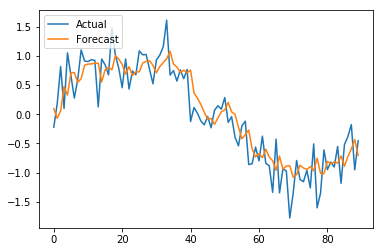

In [9]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(2000,1,hidden=1,learning_rat=0.001)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

0 	MSE: 0.414477
100 	MSE: 0.283586
200 	MSE: 0.182772
300 	MSE: 0.137635
400 	MSE: 0.125891
500 	MSE: 0.123985
600 	MSE: 0.123736
700 	MSE: 0.123663
800 	MSE: 0.123608
900 	MSE: 0.123559
1000 	MSE: 0.123516
1100 	MSE: 0.123478
1200 	MSE: 0.123445
1300 	MSE: 0.123415
1400 	MSE: 0.123388
1500 	MSE: 0.123363
1600 	MSE: 0.12334
1700 	MSE: 0.123317
1800 	MSE: 0.123295
1900 	MSE: 0.123274
2000 	MSE: 0.123253
2100 	MSE: 0.123231
2200 	MSE: 0.12321
2300 	MSE: 0.123189
2400 	MSE: 0.123167
2500 	MSE: 0.123146
2600 	MSE: 0.123125
2700 	MSE: 0.123104
2800 	MSE: 0.123083
2900 	MSE: 0.123063
0.123063
0.116377
0 	MSE: 0.571082
100 	MSE: 0.543514
200 	MSE: 0.484815
300 	MSE: 0.3911
400 	MSE: 0.283022
500 	MSE: 0.198764
600 	MSE: 0.15432
700 	MSE: 0.137287
800 	MSE: 0.132173
900 	MSE: 0.130814
1000 	MSE: 0.130362
1100 	MSE: 0.130083
1200 	MSE: 0.129831
1300 	MSE: 0.129582
1400 	MSE: 0.129332
1500 	MSE: 0.129079
1600 	MSE: 0.128822
1700 	MSE: 0.128561
1800 	MSE: 0.128295
1900 	MSE: 0.128024
2000 	MSE: 

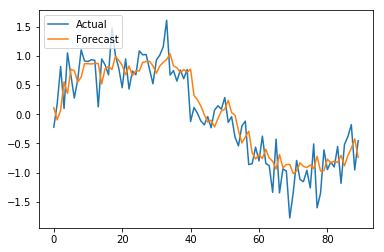

In [6]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(3000,1,hidden=1,learning_rat=0.001)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

0 	MSE: 0.744096
100 	MSE: 0.124515
200 	MSE: 0.12317
300 	MSE: 0.122776
400 	MSE: 0.122753
0.122753
0.115297
0 	MSE: 0.870256
100 	MSE: 0.12912
200 	MSE: 0.122942
300 	MSE: 0.122744
400 	MSE: 0.122671
0.122671
0.0993056
0 	MSE: 0.686313
100 	MSE: 0.143742
200 	MSE: 0.128887
300 	MSE: 0.128644
400 	MSE: 0.128629
0.128629
0.111188
0 	MSE: 0.134483
100 	MSE: 0.126724
200 	MSE: 0.126723
300 	MSE: 0.126723
400 	MSE: 0.126839
0.126839
0.125603
0 	MSE: 1.35738
100 	MSE: 0.124211
200 	MSE: 0.115531
300 	MSE: 0.114947
400 	MSE: 0.114923
0.114923
0.0868292
0 	MSE: 1.12967
100 	MSE: 0.134077
200 	MSE: 0.12636
300 	MSE: 0.125427
400 	MSE: 0.125341
0.125341
0.0862547
0 	MSE: 0.335419
100 	MSE: 0.116264
200 	MSE: 0.11609
300 	MSE: 0.116085
400 	MSE: 0.116102
0.116102
0.109329
0 	MSE: 3.20842
100 	MSE: 0.139346
200 	MSE: 0.129257
300 	MSE: 0.121572
400 	MSE: 0.11965
0.11965
0.0888053
0 	MSE: 0.39291
100 	MSE: 0.13648
200 	MSE: 0.135393
300 	MSE: 0.135304
400 	MSE: 0.135394
0.135394
0.103986
0 	MSE: 

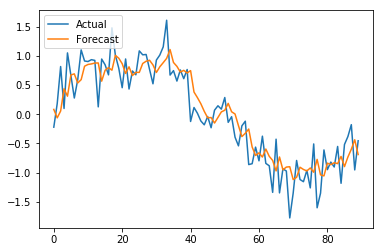

In [7]:
mse=[]
for i in range (10):
    np.random.seed(i)
    x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
    tf.set_random_seed(i)
    mse_test,y_pred=run_graph(500,1,hidden=1,learning_rat=0.1)
    mse.append(mse_test)
visualisation()
print("Mean of MSE for the model:{}".format(np.mean(mse)))
print("Variance of MSE for the model:{}".format(np.var(mse)))

# Extraction of weights/internal states during the training

In [77]:
def run_graph(epochs,time_wind,hidden=150,learning_rat=0.0065,output=1,batch_size=90):
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,batch_size,time_wind])
    Y=tf.placeholder(tf.float32,[None,batch_size,output])
    tf.set_random_seed(1)
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden)#,activation=tf.nn.relu)
    rnn_output, states=tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)
    stacked_rnn_output=tf.reshape(rnn_output,[-1,hidden])
    stacked_outputs=tf.layers.dense(stacked_rnn_output,output)
    outputs=tf.reshape(stacked_outputs,[-1,batch_size,output])
    loss=tf.reduce_mean(tf.squared_difference(outputs, Y))
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rat)
    training_op=optimizer.minimize(loss)
    
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            sess.run(training_op,feed_dict={X: x_batches, Y: y_batches})
            if ep % 100 == 0:
                mse=loss.eval(feed_dict={X: x_batches, Y: y_batches})
                out=states.eval(feed_dict={X: x_batches, Y: y_batches})
                #print(ep,"\tMSE:",mse)
                print(ep,"\tMSE:",out)
                variables_names =[v.name for v in tf.trainable_variables()]
                values = sess.run(variables_names)
                for k,v in zip(variables_names, values):
                    print(k, v)
        
        y_pred=sess.run(outputs,feed_dict={X:x_test})
        mse_test=loss.eval(feed_dict={X:x_test,Y:y_test})
    
    
        print(mse)
        print(mse_test)
        print(np.shape(out))
        
    sess.close() 
    return mse_test, y_pred

In [78]:
np.random.seed(10)
x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
print(np.shape(x_batches),np.shape(x_test))
mse_test,y_pred=run_graph(500,1,hidden=1,learning_rat=0.001)

(10, 90, 1) (1, 90, 1)
0 	MSE: [[-0.80148208]
 [-0.7619794 ]
 [-0.79551589]
 [-0.43674561]
 [-0.09718178]
 [ 0.69425875]
 [ 0.78436369]
 [ 0.70349026]
 [ 0.32735193]
 [-0.19496466]]
rnn/basic_rnn_cell/weights:0 [[ 0.68133515]
 [ 0.43641502]]
rnn/basic_rnn_cell/biases:0 [ 0.00099965]
dense/kernel:0 [[ 0.19464941]]
dense/bias:0 [-0.00099997]
100 	MSE: [[-0.86958319]
 [-0.83782202]
 [-0.8645851 ]
 [-0.51233661]
 [-0.06863219]
 [ 0.78750926]
 [ 0.85809004]
 [ 0.79600257]
 [ 0.44408745]
 [-0.27477351]]
rnn/basic_rnn_cell/weights:0 [[ 0.78093708]
 [ 0.53871965]]
rnn/basic_rnn_cell/biases:0 [ 0.00887346]
dense/kernel:0 [[ 0.29417595]]
dense/bias:0 [-0.00758705]
200 	MSE: [[-0.91562229]
 [-0.89100468]
 [-0.91112691]
 [-0.60080785]
 [-0.03040172]
 [ 0.84884858]
 [ 0.90327495]
 [ 0.85653448]
 [ 0.54301763]
 [-0.37574634]]
rnn/basic_rnn_cell/weights:0 [[ 0.87121183]
 [ 0.63633603]]
rnn/basic_rnn_cell/biases:0 [ 0.00857635]
dense/kernel:0 [[ 0.38937607]]
dense/bias:0 [-0.00907147]
300 	MSE: [[-0.9

In [43]:
np.random.seed(10)
x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
#tf.set_random_seed(10)
mse_test,y_pred=run_graph(1000,1,hidden=1,learning_rat=0.001)

0 	MSE: [[-0.4804616 ]
 [-0.45135626]
 [-0.48130006]
 [-0.20826243]
 [-0.04230278]
 [ 0.40176362]
 [ 0.49512726]
 [ 0.40362781]
 [ 0.16675319]
 [-0.10358112]]
rnn/basic_rnn_cell/weights:0 [[ 0.29553705]
 [ 0.46091586]]
rnn/basic_rnn_cell/biases:0 [-0.00099803]
dense/kernel:0 [[ 0.08478029]]
dense/bias:0 [-0.00099996]
100 	MSE: [[-0.65472382]
 [-0.62547696]
 [-0.65643972]
 [-0.29947475]
 [-0.02116086]
 [ 0.5867151 ]
 [ 0.6777696 ]
 [ 0.58901262]
 [ 0.29924083]
 [-0.18655069]]
rnn/basic_rnn_cell/weights:0 [[ 0.40394947]
 [ 0.575243  ]]
rnn/basic_rnn_cell/biases:0 [ 0.00534988]
dense/kernel:0 [[ 0.18928324]]
dense/bias:0 [-0.0059124]
200 	MSE: [[-0.79556191]
 [-0.76982898]
 [-0.79554278]
 [-0.43174803]
 [ 0.03679736]
 [ 0.73371762]
 [ 0.80397093]
 [ 0.73728031]
 [ 0.45221338]
 [-0.32688311]]
rnn/basic_rnn_cell/weights:0 [[ 0.51166117]
 [ 0.69991356]]
rnn/basic_rnn_cell/biases:0 [ 0.0064182]
dense/kernel:0 [[ 0.29908857]]
dense/bias:0 [-0.00773526]
300 	MSE: [[-0.87180644]
 [-0.85015488]
 

In [44]:
np.random.seed(10)
x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),1)
tf.set_random_seed(10)
mse_test,y_pred=run_graph(500,1,hidden=2,learning_rat=0.001)

0 	MSE: [[ 0.68294543  0.69274843]
 [ 0.57829565  0.67696708]
 [ 0.56213599  0.7353403 ]
 [ 0.21241023  0.40363112]
 [ 0.1725128   0.03672444]
 [-0.56956208 -0.56810415]
 [-0.55825895 -0.7225312 ]
 [-0.33369902 -0.68215466]
 [ 0.04643613 -0.37335402]
 [ 0.24184768  0.08037702]]
rnn/basic_rnn_cell/weights:0 [[-0.70156091 -0.45536786]
 [-0.80187768  0.59120959]
 [ 0.32452995  0.22963758]]
rnn/basic_rnn_cell/biases:0 [-0.00099996 -0.00099981]
dense/kernel:0 [[ 1.17262006]
 [-0.57897151]]
dense/bias:0 [-0.00099997]
100 	MSE: [[ 0.58188689  0.7799347 ]
 [ 0.47028118  0.76409781]
 [ 0.45475036  0.8139962 ]
 [ 0.1082449   0.46912301]
 [ 0.13751271 -0.01083052]
 [-0.52287042 -0.69214058]
 [-0.52511793 -0.81244206]
 [-0.37368482 -0.76542532]
 [-0.08538646 -0.43809527]
 [ 0.15607342  0.12995361]]
rnn/basic_rnn_cell/weights:0 [[-0.60606706 -0.55127567]
 [-0.76153755  0.69117707]
 [ 0.22939308  0.32815638]]
rnn/basic_rnn_cell/biases:0 [-0.09884689  0.02427484]
dense/kernel:0 [[ 1.0791539 ]
 [-0.67

In [50]:
x_batches, y_batches, x_test, y_test=data_preparation(generate_data(),3)
tf.set_random_seed(10)
mse_test,y_pred=run_graph(500,3,hidden=3,learning_rat=0.001)

0 	MSE: [[ 0.14637841 -0.50527912  0.67809051]
 [ 0.51664066 -0.65778869  0.82440197]
 [ 0.21967775 -0.55956531  0.73882091]
 [ 0.35180855 -0.50315768  0.79752332]
 [-0.1136639   0.07670507  0.04529829]
 [-0.17277415  0.4888317  -0.61886716]
 [-0.64900559  0.66760498 -0.80485237]
 [-0.28854129  0.67740363 -0.81655657]
 [-0.54414666  0.387353   -0.67464626]]
rnn/basic_rnn_cell/weights:0 [[-0.75814915  0.67358404 -0.23503774]
 [-0.21000703  0.58667821 -0.53900236]
 [ 0.25114602  0.29517347 -0.30976349]
 [ 0.15116937 -0.50231522 -0.73860872]
 [ 0.33791131 -0.60699862 -0.56432968]
 [-0.08312671  0.56936485  0.12356268]]
rnn/basic_rnn_cell/biases:0 [-0.00099999 -0.00099997 -0.00099771]
dense/kernel:0 [[-1.1117363 ]
 [-0.32926327]
 [ 0.10989647]]
dense/bias:0 [ 0.00099999]
100 	MSE: [[ 0.43844116 -0.40710673  0.70311248]
 [ 0.77279752 -0.5343945   0.87044376]
 [ 0.57137996 -0.39139128  0.80209094]
 [ 0.60767949 -0.39306322  0.83286762]
 [-0.17523451  0.09540002  0.02702839]
 [-0.43633473  0.

In [57]:
def data_preparation_1(data,time_wind,batch_size=1,output=1):
    data_train=data[:901]
    x_train=[]
    for i in range((len(data_train)-1)-(time_wind-1)):
        x_train.append(data_train[i:(i+time_wind)])
    x_train=np.array(x_train)
    x_batches=x_train.reshape(-1,batch_size,time_wind)
    y_train=data_train[time_wind:len(data_train)]#+3]
    y_batches=y_train.reshape(-1,batch_size,output)
    data_test=data[902:]
    x_t=[]
    for i in range((len(data_test)-1)-(time_wind-1)):
        x_t.append(data_test[i:(i+time_wind)])
    x_t=np.array(x_t)
    x_test=x_t.reshape(-1,batch_size,time_wind)
    y_t=data_test[time_wind:len(data_test)]
    y_test=y_t.reshape(-1,batch_size,output)
    return x_batches, y_batches, x_test, y_test

In [71]:
np.random.seed(10)
x_batches, y_batches, x_test, y_test=data_preparation_1(generate_data(),1)
#tf.set_random_seed(10)
print(np.shape(x_batches),np.shape(x_test))
mse_test,y_pred=run_graph(1000,1,hidden=1,learning_rat=0.001,batch_size=1)

(900, 1, 1) (97, 1, 1)
0 	MSE: [[  2.64720201e-01]
 [  1.85801804e-01]
 [ -2.27438107e-01]
 [  1.24310017e-01]
 [  2.87136883e-01]
 [  6.22780845e-02]
 [  2.95048714e-01]
 [  3.01606834e-01]
 [  3.16824585e-01]
 [  3.17073196e-01]
 [  4.52619731e-01]
 [  5.91000021e-01]
 [  2.61899382e-01]
 [  6.08069420e-01]
 [  5.15880823e-01]
 [  5.65715134e-01]
 [  3.29216033e-01]
 [  5.53685904e-01]
 [  7.25391448e-01]
 [  3.89980674e-01]
 [  2.38082111e-01]
 [  2.93675542e-01]
 [  6.18549466e-01]
 [  8.21837306e-01]
 [  7.20495462e-01]
 [  7.70769477e-01]
 [  6.03896201e-01]
 [  7.44595349e-01]
 [  5.46112061e-01]
 [  6.55150473e-01]
 [  5.31582952e-01]
 [  4.77862746e-01]
 [  5.66678584e-01]
 [  4.61122006e-01]
 [  6.86720908e-01]
 [  5.29948175e-01]
 [  5.41150749e-01]
 [  4.02526468e-01]
 [  6.18288815e-01]
 [  2.76312113e-01]
 [  4.88760829e-01]
 [  2.84305245e-01]
 [  1.34397447e-01]
 [  1.86856687e-01]
 [  8.51511508e-02]
 [  1.64559111e-01]
 [  9.87979025e-02]
 [  1.88207030e-01]
 [  1.972